<a href="https://colab.research.google.com/github/flavioloureno/Telecom-X2-ALURA-/blob/main/Challenge_TelecomX_2_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<b><font size="10">Telecom X - Parte 2</font></b>
</center>

<br/>
<center>
<b><font color="blue" size="6">Prevendo Cancelamento</font></b>
</center>


🎯 <b><font color="blue">MISSÃO:</font></b>

 - Desenvolver **modelos preditivos** capazes de prever quais clientes têm maior chance de cancelar seus serviços.

 - A empresa quer **antecipar o problema da evasão**, assim será construído um pipeline robusto para essa etapa inicial de modelagem.

🧠 <b><font color="blue">OBJETIVO DO DESAFIO:</font></b>

 - Preparar os dados para a **modelagem** (*tratamento, encoding, normalização*).

 - Realizar **análise de correlação** e seleção de variáveis.

 - Treinar dois ou mais modelos de classificação.

 - Avaliar o desempenho dos modelos com **métricas**.

 - **Interpretar os resultados**, incluindo a importância das variáveis.

 - Criar uma **conclusão estratégica** apontando os principais fatores que influenciam a evasão.

#📌 <b><font color="blue" size="6">EXTRAÇÃO</font></b>


---



Para iniciar análise, importado os [dados da API da Telecom X](https://drive.google.com/file/d/1Dul9YDaHCzXo8jFJKceEhzarRkjwLYnK/view?usp=drive_link). Esses dados estão disponíveis no formato `CSV` e contêm as informações já tratadas.

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gdown
from IPython.display import display, HTML


In [2]:
# ✅ ID do arquivo no Google Drive
file_id = '1Dul9YDaHCzXo8jFJKceEhzarRkjwLYnK'
url = f'https://drive.google.com/uc?id={file_id}'

# ⬇️ Baixar o arquivo
gdown.download(url, 'dados_tratados.csv', quiet=False)

# 📖 Ler os dados
dados = pd.read_csv('dados_tratados.csv')
dados.head()


Downloading...
From: https://drive.google.com/uc?id=1Dul9YDaHCzXo8jFJKceEhzarRkjwLYnK
To: /content/dados_tratados.csv
100%|██████████| 1.24M/1.24M [00:00<00:00, 67.3MB/s]


,ID_Cliente,Cancelamento,Gênero,Idoso,Possui_Companheiro,Possui_Dependentes,Meses_de_Contrato,Telefone_Ativo,Multiplas_Linhas,Tipo_Internet,...,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Tipo_Contrato,Fatura_Digital,Forma_Pagamento,Valor_Mensal,Valor_Total,tempo_estimado_meses,Conta_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,9.044207,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,9.055092,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,3.800406,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,12.631122,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,3.187128,2.796667


#🔧 <b><font color="blue" size="6">PREPARAÇÃO DOS DADOS</font></b>


---



## 🎯<b><font color="blue">Remoção de Colunas Irrelevantes</font></b>

Removido coluna com IDs, estimativas e valores duplicados em outras colunas. Essas colunas não ajudam na previsão da evasão e podem até prejudicar o desempenho dos modelos.

In [3]:
# Calcular correlação apenas entre colunas numéricas
dados_numericos = dados.select_dtypes(include=['number', 'bool'])
correlacao = dados_numericos.corr().abs()

# Pegar pares com alta correlação
pares_correlacionados = [
    (col1, col2)
    for col1 in correlacao.columns
    for col2 in correlacao.columns
    if col1 != col2 and correlacao.loc[col1, col2] > 0.95
]

print("🔁 PARES DE COLUNAS COM ALTA CORRELAÇÃO:")
print('-'*41)
for col1, col2 in pares_correlacionados:
    print(f"{col1}  🔛  {col2}")


🔁 PARES DE COLUNAS COM ALTA CORRELAÇÃO:
-----------------------------------------
Meses_de_Contrato  🔛  tempo_estimado_meses
Valor_Mensal  🔛  Conta_Diarias
tempo_estimado_meses  🔛  Meses_de_Contrato
Conta_Diarias  🔛  Valor_Mensal


In [4]:
# Remover as colunas com alta correlação
dados = dados.drop(['ID_Cliente', 'tempo_estimado_meses', 'Conta_Diarias', 'Valor_Total'], axis=1)

# Remover registros onde o valor é 'Não informado'
dados = dados[dados['Cancelamento'] != 'Não informado']


dados.head()

,Cancelamento,Gênero,Idoso,Possui_Companheiro,Possui_Dependentes,Meses_de_Contrato,Telefone_Ativo,Multiplas_Linhas,Tipo_Internet,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Tipo_Contrato,Fatura_Digital,Forma_Pagamento,Valor_Mensal
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9


## 🎯 <b><font color="blue">Encoding</font></b>

Inicialmente foi identificado os valores únicos de cada coluna e posteriormente transformado as variáveis categóricas em formato numérico para torná-las compatíveis com algoritmos de machine learning. Utilizou-se um método de codificação adequado, como o **one-hot encoding**.

In [5]:
# Para saber os valores únicos por coluna e quantidade.
for col in dados.select_dtypes(include='object').columns:
    titulo = f"<strong style='font-size: 15px;'>➡️  {col.upper()}</strong>"
    display(HTML(titulo))
    display(dados[col].value_counts(dropna=False).head(3).to_frame(name='Frequência'))
    print("-" * 35)

,Frequência
Cancelamento,
No,5163
Yes,1869


-----------------------------------


,Frequência
Gênero,
Male,3549
Female,3483


-----------------------------------


,Frequência
Possui_Companheiro,
No,3639
Yes,3393


-----------------------------------


,Frequência
Possui_Dependentes,
No,4933
Yes,2099


-----------------------------------


,Frequência
Telefone_Ativo,
Yes,6352
No,680


-----------------------------------


,Frequência
Multiplas_Linhas,
No,3385
Yes,2967
No phone service,680


-----------------------------------


,Frequência
Tipo_Internet,
Fiber optic,3096
DSL,2416
No,1520


-----------------------------------


,Frequência
Seguranca_Online,
No,3497
Yes,2015
No internet service,1520


-----------------------------------


,Frequência
Backup_Online,
No,3087
Yes,2425
No internet service,1520


-----------------------------------


,Frequência
Protecao_Dispositivo,
No,3094
Yes,2418
No internet service,1520


-----------------------------------


,Frequência
Suporte_Tecnico,
No,3472
Yes,2040
No internet service,1520


-----------------------------------


,Frequência
Streaming_TV,
No,2809
Yes,2703
No internet service,1520


-----------------------------------


,Frequência
Streaming_Filmes,
No,2781
Yes,2731
No internet service,1520


-----------------------------------


,Frequência
Tipo_Contrato,
Month-to-month,3875
Two year,1685
One year,1472


-----------------------------------


,Frequência
Fatura_Digital,
Yes,4168
No,2864


-----------------------------------


,Frequência
Forma_Pagamento,
Electronic check,2365
Mailed check,1604
Bank transfer (automatic),1542


-----------------------------------


In [6]:
# Passo 1: Mapear os valores para binário
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    dados = dados.replace({'Yes': 1, 'No': 0})
    dados = dados.replace({'Female': 1, 'Male': 0})
    dados = dados.replace({'True': 1, 'False': 0})

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7255
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cancelamento          7032 non-null   int64  
 1   Gênero                7032 non-null   int64  
 2   Idoso                 7032 non-null   int64  
 3   Possui_Companheiro    7032 non-null   int64  
 4   Possui_Dependentes    7032 non-null   int64  
 5   Meses_de_Contrato     7032 non-null   int64  
 6   Telefone_Ativo        7032 non-null   int64  
 7   Multiplas_Linhas      7032 non-null   object 
 8   Tipo_Internet         7032 non-null   object 
 9   Seguranca_Online      7032 non-null   object 
 10  Backup_Online         7032 non-null   object 
 11  Protecao_Dispositivo  7032 non-null   object 
 12  Suporte_Tecnico       7032 non-null   object 
 13  Streaming_TV          7032 non-null   object 
 14  Streaming_Filmes      7032 non-null   object 
 15  Tipo_Contrato         7032

In [7]:
# Passo 2: Identificar colunas que têm só 0 e 1
binarias = [col for col in dados.columns if set(dados[col].dropna().unique()).issubset({0, 1})]

# Passo 3: Converter essas colunas para booleano
dados[binarias] = dados[binarias].astype(bool)

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7255
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cancelamento          7032 non-null   bool   
 1   Gênero                7032 non-null   bool   
 2   Idoso                 7032 non-null   bool   
 3   Possui_Companheiro    7032 non-null   bool   
 4   Possui_Dependentes    7032 non-null   bool   
 5   Meses_de_Contrato     7032 non-null   int64  
 6   Telefone_Ativo        7032 non-null   bool   
 7   Multiplas_Linhas      7032 non-null   object 
 8   Tipo_Internet         7032 non-null   object 
 9   Seguranca_Online      7032 non-null   object 
 10  Backup_Online         7032 non-null   object 
 11  Protecao_Dispositivo  7032 non-null   object 
 12  Suporte_Tecnico       7032 non-null   object 
 13  Streaming_TV          7032 non-null   object 
 14  Streaming_Filmes      7032 non-null   object 
 15  Tipo_Contrato         7032

In [8]:
# Passo 4: One-hot encoding para todas as colunas categóricas multiclasse
dados = pd.get_dummies(dados, drop_first=True)

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7255
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Cancelamento                              7032 non-null   bool   
 1   Gênero                                    7032 non-null   bool   
 2   Idoso                                     7032 non-null   bool   
 3   Possui_Companheiro                        7032 non-null   bool   
 4   Possui_Dependentes                        7032 non-null   bool   
 5   Meses_de_Contrato                         7032 non-null   int64  
 6   Telefone_Ativo                            7032 non-null   bool   
 7   Fatura_Digital                            7032 non-null   bool   
 8   Valor_Mensal                              7032 non-null   float64
 9   Multiplas_Linhas_1                        7032 non-null   bool   
 10  Multiplas_Linhas_No phone service        

In [9]:
# Passo 5: Calcular novamente a correlação apenas entre colunas numéricas
dados_numericos = dados.select_dtypes(include=['number', 'bool'])
correlacao = dados_numericos.corr().abs()

# Pegar pares com alta correlação
pares_correlacionados = [
    (col1, col2)
    for col1 in correlacao.columns
    for col2 in correlacao.columns
    if col1 != col2 and correlacao.loc[col1, col2] > 0.95
]

print("🔁 PARES DE COLUNAS COM ALTA CORRELAÇÃO:")
print('-'*40)
for col1, col2 in pares_correlacionados:
    print(f"{col1}  🔛  {col2}")


🔁 PARES DE COLUNAS COM ALTA CORRELAÇÃO:
----------------------------------------
Telefone_Ativo  🔛  Multiplas_Linhas_No phone service
Multiplas_Linhas_No phone service  🔛  Telefone_Ativo
Seguranca_Online_No internet service  🔛  Backup_Online_No internet service
Seguranca_Online_No internet service  🔛  Protecao_Dispositivo_No internet service
Seguranca_Online_No internet service  🔛  Suporte_Tecnico_No internet service
Seguranca_Online_No internet service  🔛  Streaming_TV_No internet service
Seguranca_Online_No internet service  🔛  Streaming_Filmes_No internet service
Backup_Online_No internet service  🔛  Seguranca_Online_No internet service
Backup_Online_No internet service  🔛  Protecao_Dispositivo_No internet service
Backup_Online_No internet service  🔛  Suporte_Tecnico_No internet service
Backup_Online_No internet service  🔛  Streaming_TV_No internet service
Backup_Online_No internet service  🔛  Streaming_Filmes_No internet service
Protecao_Dispositivo_No internet service  🔛  Seguranc

In [10]:
# Passo 6: Remover colunas com alta correlação:
dados = dados.drop([ 'Multiplas_Linhas_No phone service',
    'Backup_Online_No internet service',
    'Protecao_Dispositivo_No internet service',
    'Suporte_Tecnico_No internet service',
    'Streaming_TV_No internet service',
    'Streaming_Filmes_No internet service'], axis=1)

# Remover registros onde o valor é 'Não informado'
dados = dados[dados['Cancelamento'] != 'Não informado']


dados.head()

,Cancelamento,Gênero,Idoso,Possui_Companheiro,Possui_Dependentes,Meses_de_Contrato,Telefone_Ativo,Fatura_Digital,Valor_Mensal,Multiplas_Linhas_1,...,Backup_Online_1,Protecao_Dispositivo_1,Suporte_Tecnico_1,Streaming_TV_1,Streaming_Filmes_1,Tipo_Contrato_One year,Tipo_Contrato_Two year,Forma_Pagamento_Credit card (automatic),Forma_Pagamento_Electronic check,Forma_Pagamento_Mailed check
0,False,True,False,True,True,9,True,True,65.6,False,...,True,False,True,True,False,True,False,False,False,True
1,False,False,False,False,False,9,True,False,59.9,True,...,False,False,False,False,True,False,False,False,False,True
2,True,False,False,False,False,4,True,True,73.9,False,...,False,True,False,False,False,False,False,False,True,False
3,True,False,True,True,False,13,True,True,98.0,False,...,True,True,False,True,True,False,False,False,True,False
4,True,True,True,True,False,3,True,True,83.9,False,...,False,False,True,True,False,False,False,False,False,True


## 🎯 <b><font color="blue">Verificação da Proporção de Evasão</font></b>

Calculamos a proporção de clientes cancelados (evadidos) e os que permaneceram. A distribuição será usada para definir se o dataset está balanceado.

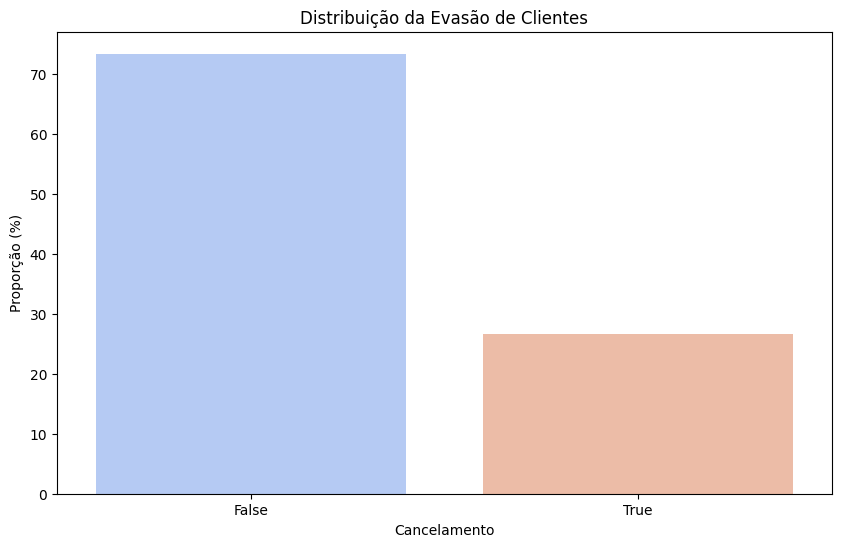


📊 FREQUENCIA ABSOLUTA:
-----------------------
Cancelamento
False    5163
True     1869
Name: count, dtype: int64
-

📈 PROPORÇÃO (%):
-----------------
Cancelamento
False    73.421502
True     26.578498
Name: proportion, dtype: float64
-



In [11]:
# Frequência absoluta e relativa da coluna Cancelamento
frequencia = dados['Cancelamento'].value_counts()
proporcao = dados['Cancelamento'].value_counts(normalize=True) * 100

# Visualizar com gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=proporcao.index, y=proporcao.values, hue=proporcao.index, palette='coolwarm', legend=False)
plt.ylabel('Proporção (%)')
plt.title('Distribuição da Evasão de Clientes')
plt.show()

# Exibir os resultados
print("\n📊 FREQUENCIA ABSOLUTA:")
print("-" * 23)
print(frequencia)
print("-\n" * 1)
print("📈 PROPORÇÃO (%):")
print("-" * 17)
print(proporcao)
print("-\n")



###📌 Após rodar seu código, veja:


 - **Equilíbrio**: Quando as classes estão próximas de 50% / 50%.

 - **Gerenciável quando próximo de 70% / 30%** .Se 70% dos clientes permaneceram e 30% cancelaram, ainda é possível treinar bons modelos com técnicas de balanceamento

 - **Desequilíbrio forte**: Quando uma classe tem 80% ou mais dos registros (ex: 80% "Não" e 20% "Sim"), o modelo pode ignorar a classe minoritária, e será importante:

  - Aplicar técnicas de balanceamento (como oversampling com SMOTE, undersampling, etc.);

  - Escolher métricas apropriadas (como f1-score, recall, AUC) — e não apenas acurácia.

## 🎯 <b><font color="blue">Balanceamento de Classes</font></b>

Para aprofundar a análise, foi aplicado técnicas de balanceamento como **undersampling** , **oversampling** e **SMOTE**. Em situações de forte desbalanceamento, ferramentas como o **SMOTE** podem ser úteis para gerar exemplos sintéticos da classe minoritária.

In [12]:
# Separar features(X) e target(y)
X = dados.drop('Cancelamento', axis=1)
y = dados['Cancelamento']


In [13]:
# Oversampling com RandomOverSampler (Duplica registros da classe minoritária)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print("DISTRIBUIÇÃO APÓS OVERSAMPLING:")
print("-" * 31)
print(pd.Series(y_res).value_counts())


DISTRIBUIÇÃO APÓS OVERSAMPLING:
-------------------------------
Cancelamento
False    5163
True     5163
Name: count, dtype: int64


In [14]:
# Undersampling com RandomUnderSampler (Remove registros da classe majoritária)
# Gera novas amostras sintéticas da classe minoritária, em vez de apenas copiar.

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print("DISTRIBUIÇÃO APÓS UNDERSAMPLING:")
print("-" * 32)
print(pd.Series(y_res).value_counts())


DISTRIBUIÇÃO APÓS UNDERSAMPLING:
--------------------------------
Cancelamento
False    1869
True     1869
Name: count, dtype: int64


In [15]:
# SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("DISTRIBUIÇÃO APÓS SMOTE:")
print("-" * 24)
print(pd.Series(y_res).value_counts())



DISTRIBUIÇÃO APÓS SMOTE:
------------------------
Cancelamento
False    5163
True     5163
Name: count, dtype: int64


### 🧪 **Balanceamento de Classes**

Antes da criação dos modelos, foi analisada a proporção entre as classes da variável-alvo `Cancelamento`, que indica se o cliente **evadiu** (1) ou **permaneceu** (0). Identificou-se um desequilíbrio entre as classes, o que poderia comprometer o desempenho preditivo dos algoritmos, especialmente em relação à detecção de clientes propensos à evasão.

Para lidar com esse problema, foram testadas três técnicas de balanceamento:

- **Oversampling com `RandomOverSampler`**: Aumenta a quantidade da classe minoritária replicando seus exemplos.
- **Undersampling com `RandomUnderSampler`**: Reduz a quantidade da classe majoritária removendo exemplos.
- **`SMOTE` (Synthetic Minority Over-sampling Technique)**: Gera exemplos sintéticos da classe minoritária com base nos vizinhos mais próximos.

Após a comparação das distribuições, optou-se por seguir com a técnica **SMOTE**, pois ela mantém todos os dados originais e cria novos registros de forma artificial, evitando duplicações e reduzindo o risco de overfitting.

Os dados balanceados foram então utilizados para treinar e avaliar os modelos preditivos. O desempenho foi posteriormente analisado por meio de métricas como **precisão**, **recall**, **f1-score** e **matriz de confusão**, que serão apresentados nas próximas etapas.


## 🎯  <b><font color="blue">Normalização ou Padronização </font></b>

Foi avaliado a necessidade de normalizar ou padronizar os dados, conforme os modelos que serão aplicados.
Modelos baseados em distância, como KNN, SVM, Regressão Logística e Redes Neurais, requerem esse pré-processamento.
Já modelos baseados em árvore, como Decision Tree, Random Forest e XGBoost, não são sensíveis à escala dos dados.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar X e y
X = dados.drop(columns=['Cancelamento'])
y = dados['Cancelamento']

# Dividir treino e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Identificar colunas numéricas para padronizar
colunas_numericas = ['Meses_de_Contrato', 'Valor_Mensal']

# Criar cópias para não modificar original
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Aplicar StandardScaler só nas colunas numéricas
scaler = StandardScaler()
X_train_scaled[colunas_numericas] = scaler.fit_transform(X_train[colunas_numericas])
X_test_scaled[colunas_numericas] = scaler.transform(X_test[colunas_numericas])

# Agora se pode usar X_train_scaled e X_test_scaled para treinar modelos sensíveis à escala.


### ⚙️ **Normalização / Padronização dos Dados**

Como parte do pré-processamento, foi aplicada a **padronização** dos atributos numéricos, utilizando a técnica `StandardScaler`, que transforma os dados para que tenham média zero e desvio padrão um.

Esse passo é fundamental para o bom desempenho de algoritmos que são sensíveis à escala dos dados, como:

- **KNN** (K-Nearest Neighbors)
- **SVM** (Support Vector Machines)
- **Regressão Logística**
- **Redes Neurais**

A padronização foi aplicada **apenas após o balanceamento das classes e a separação entre dados de treino e teste**, para evitar vazamento de dados e garantir que as transformações ocorram apenas com base nos dados de treino. Com isso, garantimos uma comparação justa e válida durante a avaliação dos modelos.


# 📊 <b><font color="blue" size="6">CORRELAÇÃO E SELEÇÃO DE VARIÁVEIS</font></b>



## 🎯 <b><font color="green">Análise de Correlação</font></b>

A matriz de correlação é útil para identificar relações entre variáveis numéricas. Observe especialmente quais variáveis apresentam maior correlação com a evasão, pois elas podem ser fortes candidatas para o modelo preditivo.

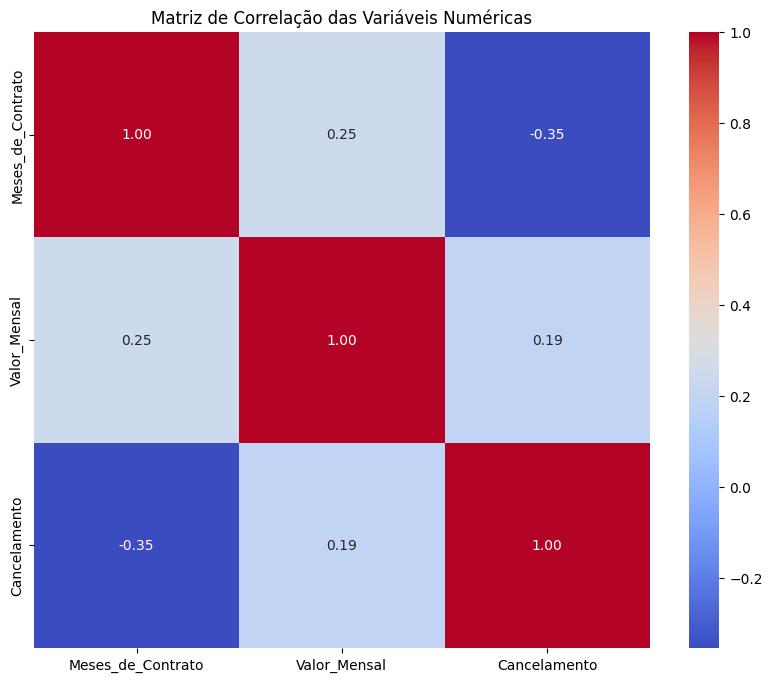

In [17]:
# Identificar as colunas numéricas automaticamente
colunas_numericas = dados.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Para garantir que a coluna alvo 'Cancelamento' esteja incluída
if 'Cancelamento' not in colunas_numericas:
    colunas_numericas.append('Cancelamento')

# Criar um DataFrame apenas com as colunas numéricas
dados_numericos = dados[colunas_numericas]


# Calcular matriz de correlação
corr = dados_numericos.corr()

# Visualizar matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()


# Analisar correlação com evasão ---
corr_com_alvo = corr['Cancelamento'].drop('Cancelamento').sort_values(ascending=False)


### 🔍 **Análise de Correlação**

Foi utilizada a matriz de correlação para identificar possíveis relações entre as variáveis numéricas e a variável-alvo `Cancelamento`. A análise permite identificar variáveis que apresentam maior influência na evasão dos clientes.

A matriz de correlação retornou as variáveis `Meses_de_Contrato` e `Valor_Mensal`, pois são as únicas variáveis numéricas contínuas do conjunto de dados. As demais variáveis são majoritariamente binárias (indicadoras), o que limita sua visualização na matriz padrão.

Para complementar, foi plotado um gráfico com as variáveis mais correlacionadas com `Cancelamento`, com o objetivo de enriquecer a análise e identificar fatores relevantes para a evasão:

 - A **correlação entre “Meses_de_Contrato” e “Valor_Mensal”  é fraca (0.25)**.

 - A **correlação entre “Meses_de_Contrato” e “Cancelamento”  é fraca (0.35)**.

 - A **correlação entre “Valor_Mensal” e “Cancelamento”  é fraca (0.19)**.

🔎 *Isso sugere que não há uma relação linear forte entre o tempo de contrato e o valor pago mensalmente, e entre cada uma das variáveis com o cancelamento.*

## 🎯 <b><font color="green">Análise Direcionadas</font></b>

Nesta etapa, analisamos como duas variáveis principais — **Meses de Contrato** e **Valor Mensal** — se comportam em relação ao **Cancelamento (Evasão)** dos clientes.

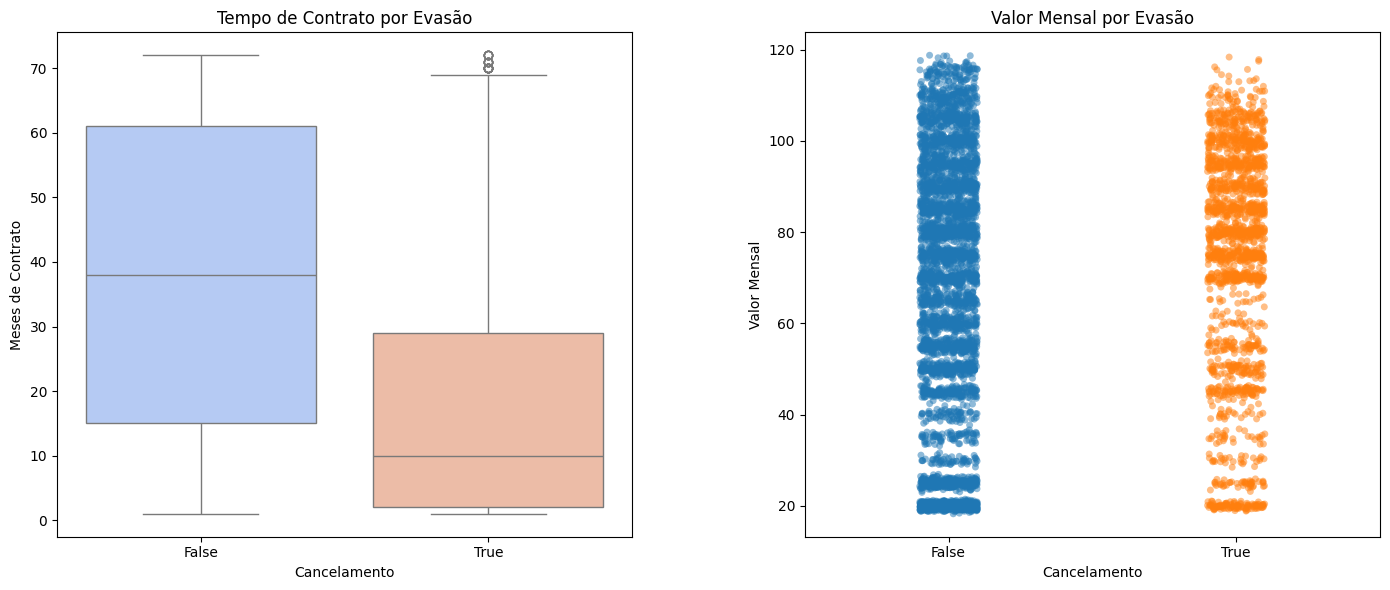

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 linha, 2 colunas

# Boxplot com hue e legend=False para evitar warning
sns.boxplot(ax=axes[0], x='Cancelamento', y='Meses_de_Contrato', hue='Cancelamento', palette='coolwarm', data=dados, legend=False)
axes[0].set_title('Tempo de Contrato por Evasão',fontsize=12)
axes[0].set_ylabel('Meses de Contrato')

sns.stripplot(ax=axes[1], x='Cancelamento', y='Valor_Mensal', hue='Cancelamento',jitter=True, alpha=0.5, data=dados, legend=False)
axes[1].set_title('Valor Mensal por Evasão', fontsize=12)
axes[1].set_ylabel('Valor Mensal')

plt.tight_layout()

# Aumenta o espaço horizontal entre os gráficos
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()



### 🎯 **Análise Direcionada**



---

#### 📊 **Gráfico 1**: *Boxplot - Tempo de Contrato por Evasão*

O **boxplot** apresenta a distribuição dos **meses de contrato** para clientes que **permaneceram (0)** e os que **evadiram (1)**.

- A mediana (linha central da caixa) mostra a tendência central de cada grupo.
- As caixas representam o intervalo interquartil (50% central dos dados).
- Pontos fora da caixa (outliers) indicam clientes com tempos de contrato muito diferentes da maioria.

⇣⇣⇣

**🧐 Interpretação:**  
Podemos observar que clientes que evadiram tendem a ter um **tempo de contrato menor** do que os que permaneceram. Isso pode indicar que a evasão ocorre mais frequentemente nos primeiros meses de contrato.

---

#### 🎯 **Gráfico 2**: *Stripplot - Valor Mensal por Evasão*

O **stripplot** (também chamado de *scatter plot categórico*) mostra **cada cliente individualmente**, posicionando seus **valores mensais** em relação à evasão.

- Cada ponto representa um cliente.
- Os pontos estão "espalhados" horizontalmente (via `jitter`) para facilitar a visualização da densidade.

⇣⇣⇣

**🧐 Interpretação:**

Apesar de haver sobreposição, é possível notar uma **concentração maior de valores mensais mais altos entre os clientes que evadiram (1)**, sugerindo que **valores mais elevados podem estar relacionados à evasão**.

---

Esses dois gráficos ajudam a entender melhor **quais fatores estão associados à decisão dos clientes em cancelar os serviços.**


# 🤖 <b><font color="blue" size="6">MODELAGEM PREDITIVA</font></b>

## 🎯 <b><font color="blue">Separação de Dados</font></b>

Uma divisão comum é 70% para treino e 30% para teste, ou 80/20, dependendo do tamanho da base de dados.

In [19]:
# Dividir treino e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## 🎯 <b><font color="blue">Criação de Modelos</font></b>

Foi criado 4 modelos diferentes para prever a evasão de clientes:

 - *Regressão Logística* e *KNN* que exige normalização.

 - *Árvore de Decisão* e *Random Forest* que não exige normalização.


In [20]:
# MODELO 1: Regressão Logística (com normalização)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Normalização apenas para o Modelo 1
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Treinar modelo com dados normalizados
modelo_log = LogisticRegression()
modelo_log.fit(X_train_norm, y_train)

# Previsões
y_pred_log = modelo_log.predict(X_test_norm)

# Avaliação
print("🔍 REGRESSÃO LOGÍSTICA")
print("-" * 23)
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


🔍 REGRESSÃO LOGÍSTICA
-----------------------
[[930 103]
 [179 195]]
              precision    recall  f1-score   support

       False       0.84      0.90      0.87      1033
        True       0.65      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [21]:
# MODELO 2: Random Forest

from sklearn.ensemble import RandomForestClassifier

# Treinar modelo com dados originais
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)

# Previsões
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação
print("🌳 RANDOM FOREST")
print("-" * 17)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

🌳 RANDOM FOREST
-----------------
[[936  97]
 [199 175]]
              precision    recall  f1-score   support

       False       0.82      0.91      0.86      1033
        True       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



In [22]:
# MODELO 3: KNN - K Vizinhos Mais Próximos (com normalização)
from sklearn.neighbors import KNeighborsClassifier

modelo_knn = KNeighborsClassifier(n_neighbors=5)
modelo_knn.fit(X_train_norm, y_train)
y_pred_knn = modelo_knn.predict(X_test_norm)

# Avaliação
print("🔍 KNN")
print("-" * 10)
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

🔍 KNN
----------
[[880 153]
 [189 185]]
              precision    recall  f1-score   support

       False       0.82      0.85      0.84      1033
        True       0.55      0.49      0.52       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.75      1407



In [23]:
# MODELO 4: Árvore de Decisão (sem normalização)
from sklearn.tree import DecisionTreeClassifier

modelo_dt = DecisionTreeClassifier(random_state=42)
modelo_dt.fit(X_train, y_train)
y_pred_dt = modelo_dt.predict(X_test)

# Avaliação
print("🌳 ÁRVORE DE DECISÃO")
print("-" * 21)
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


🌳 ÁRVORE DE DECISÃO
---------------------
[[833 200]
 [185 189]]
              precision    recall  f1-score   support

       False       0.82      0.81      0.81      1033
        True       0.49      0.51      0.50       374

    accuracy                           0.73      1407
   macro avg       0.65      0.66      0.65      1407
weighted avg       0.73      0.73      0.73      1407



In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Função para gerar métricas + matriz de confusão como string
def gerar_metricas(nome, modelo, X_test, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_str = f"[[{cm[0][0]}, {cm[0][1]}], [{cm[1][0]}, {cm[1][1]}]]"

    return {
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Matriz de Confusão': cm_str
    }

# Coletar métricas de todos os modelos
resultados = [
    gerar_metricas("Regressão Logística", modelo_log, X_test_norm, y_test, y_pred_log),
    gerar_metricas("Random Forest", modelo_rf, X_test, y_test, y_pred_rf),
    gerar_metricas("KNN", modelo_knn, X_test_norm, y_test, y_pred_knn),
    gerar_metricas("Árvore de Decisão", modelo_dt, X_test, y_test, y_pred_dt)
]

# Criar DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='F1-Score', ascending=False)

# Exibir a tabela
print("📊 COMPARATIVO DE MODELOS")
print("-" * 26)
display(df_resultados.round(4))



📊 COMPARATIVO DE MODELOS
--------------------------


,Modelo,Acurácia,Precisão,Recall,F1-Score,Matriz de Confusão
0,Regressão Logística,0.7996,0.6544,0.5214,0.5804,"[[930, 103], [179, 195]]"
1,Random Forest,0.7896,0.6434,0.4679,0.5418,"[[936, 97], [199, 175]]"
2,KNN,0.7569,0.5473,0.4947,0.5197,"[[880, 153], [189, 185]]"
3,Árvore de Decisão,0.7264,0.4859,0.5053,0.4954,"[[833, 200], [185, 189]]"


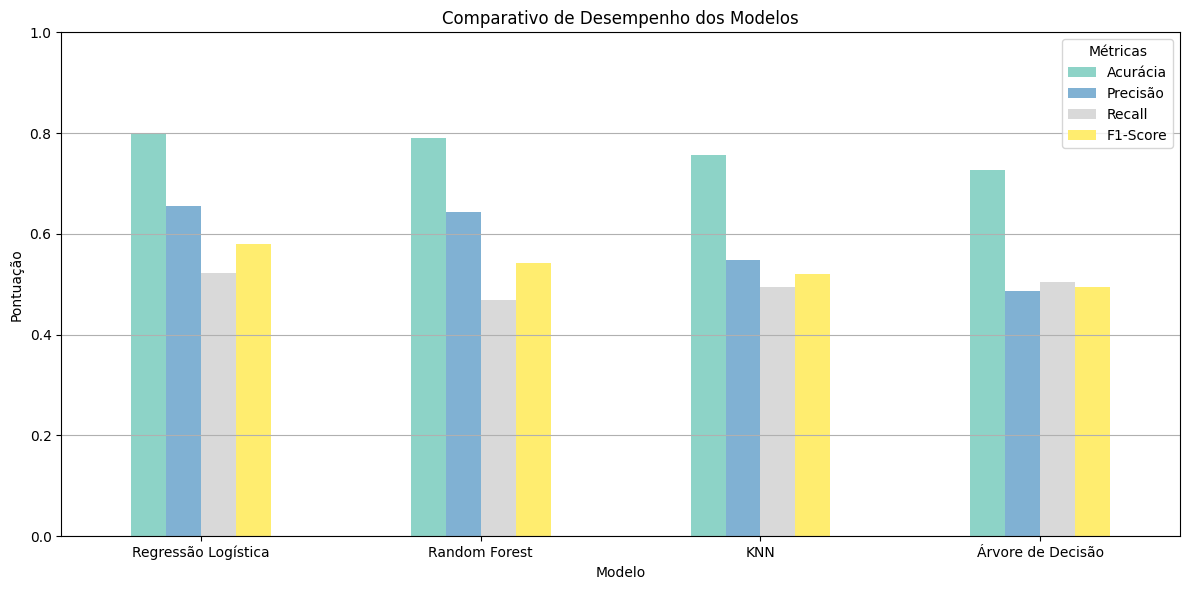

In [25]:
# Criar DataFrame com os dados fornecidos
dados_modelos = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'KNN', 'Árvore de Decisão'],
    'Acurácia': [0.7996, 0.7896, 0.7569, 0.7264],
    'Precisão': [0.6544, 0.6434, 0.5473, 0.4859],
    'Recall': [0.5214, 0.4679, 0.4947, 0.5053],
    'F1-Score': [0.5804, 0.5418, 0.5197, 0.4954]
})

# Plotar gráfico de barras para cada métrica
dados_modelos.set_index('Modelo').plot(kind='bar', figsize=(12, 6), colormap='Set3')
plt.title('Comparativo de Desempenho dos Modelos')
plt.ylabel('Pontuação')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Métricas')
plt.tight_layout()
plt.show()


## 🤖  <b><font color="blue">Avaliação dos Modelos </font></b>

Para prever a evasão de clientes, foram utilizados **quatro modelos diferentes**, com e sem normalização. Cada modelo foi avaliado utilizando as seguintes métricas:

- **Acurácia**  
- **Precisão**  
- **Recall**  
- **F1-score**  
- **Matriz de confusão**

<br/>

### 📌 **MODELO 1**: *Regressão Logística* (com normalização)

- Modelo linear, indicado para **classificação binária**.  
- Requer **normalização dos dados**, pois é sensível à escala das variáveis.  
- Fácil de interpretar e útil para identificar variáveis relevantes.  
- Serviu como **modelo base** e apresentou **o melhor desempenho geral** nas métricas.

---

### 📌 **MODELO 2**: *Random Forest* (sem normalização)

- Modelo não linear baseado em múltiplas árvores de decisão.  
- **Não precisa de normalização**, pois suas decisões são baseadas em cortes.  
- Robusto contra overfitting e apto a capturar relações complexas entre variáveis.  
- Teve desempenho sólido, porém com menor recall em comparação à regressão logística.

---

### 📌 **MODELO 3**: *KNN* – K Vizinhos Mais Próximos (com normalização)

- Classifica os clientes com base na **distância dos vizinhos mais próximos**.  
- Requer **normalização**, pois é altamente sensível à escala das variáveis.  
- Simples e intuitivo, mas pode ter **performance inferior com dados desbalanceados**.  
- Apresentou **métricas medianas** e sinal de **underfitting**.

---

### 📌 **MODELO 4**: *Árvore de Decisão* (sem normalização)

- Modelo interpretável baseado em regras do tipo "if-else".  
- **Não exige normalização**.  
- Pode se ajustar bem aos dados, mas é suscetível ao **overfitting** se não regulado.  
- Foi o modelo com **menor desempenho geral**, indicando **underfitting**.

<br/>

### 🏆 <b><font color="blue">**CONCLUSÃO** </font></b>: Melhor Modelo é **Regressão Logística**

Após aplicar e comparar os quatro modelos (Regressão Logística, Random Forest, KNN e Árvore de Decisão), considerando as métricas de desempenho (Acurácia, Precisão, Recall, F1-Score e Matriz de Confusão), conclui-se:

- 🔹 **Regressão Logística** apresentou o melhor desempenho geral:
  - Maior **acurácia (0.7996)** e **F1-Score (0.5804)**.
  - Bom equilíbrio entre **precisão (0.6544)** e **recall (0.5214)**.
  - Modelo simples, interpretável e eficiente, ideal para começar.

- 🔹 **Random Forest** teve desempenho próximo, porém com recall mais baixo, o que pode impactar a detecção de clientes que realmente evadiriam.

- 🔹 **KNN** e **Árvore de Decisão** apresentaram **desempenho inferior**, com menor F1-Score e sinais de **underfitting** (pouca capacidade de generalização).

<br/>

A <b><font color="blue">**Regressão Logística** </font></b> é o modelo mais indicado neste cenário, combinando boa performance, fácil aplicação e excelente interpretabilidade para ações estratégicas nas empresas.



#🚀 <b><font color="blue" size="6">INTERPRETAÇÃO & CONCLUSÃO</font></b>

## 🔍 <b><font color="green">Análise de Importância das Variáveis </font></b>

O gráfico abaixo exibe as variáveis mais relevantes identificadas pelo modelo **Regressão Logística**, treinado com dados normalizados, para prever a **evasão de clientes**.

As variáveis posicionadas no topo do gráfico apresentam **maior influência nas decisões do modelo**, com base na magnitude dos coeficientes. Isso significa que pequenas variações nessas variáveis têm um impacto significativo na probabilidade de um cliente cancelar os serviços.






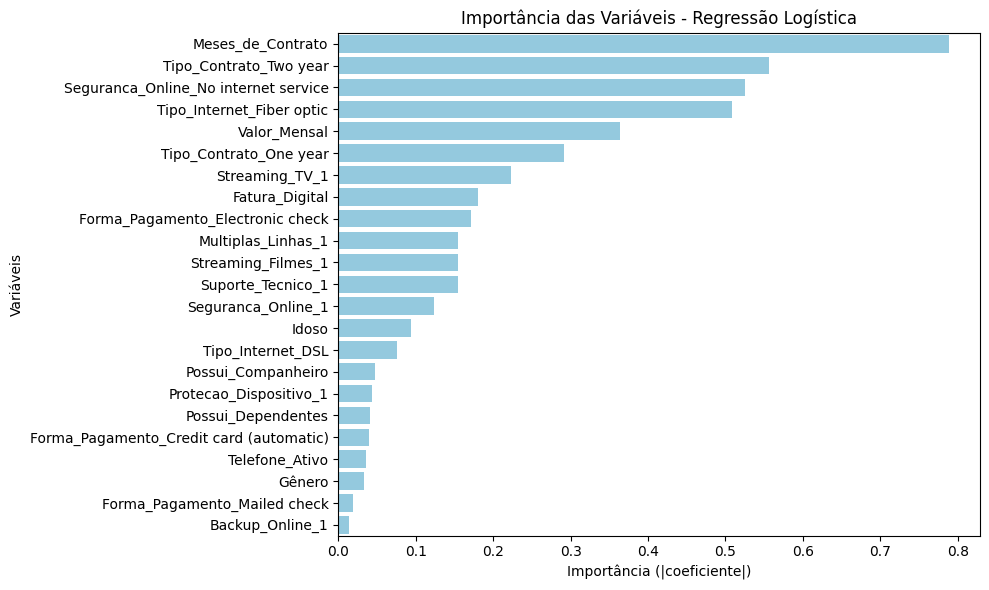

In [26]:
# Extrair coeficientes do modelo treinado
coeficientes = modelo_log.coef_[0]

# Importância: valor absoluto dos coeficientes
importancias = np.abs(coeficientes)

# Criar DataFrame com variáveis e suas importâncias
df_importancias = pd.DataFrame({
    'Variável': X_train.columns,
    'Importância': importancias
}).sort_values(by='Importância', ascending=False)

# Plotar gráfico com cor única suave, sem legenda e sem warning
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importância',
    y='Variável',
    data=df_importancias,
    color='skyblue'
)
plt.title('Importância das Variáveis - Regressão Logística')
plt.xlabel('Importância (|coeficiente|)')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# 🧠 <b><font color="blue">Conclusão Geral da Análise</font></b>

A análise preditiva de evasão de clientes realizada neste projeto possibilitou extrair insights valiosos sobre o comportamento dos usuários e os fatores que mais contribuem para o cancelamento dos serviços.

<br/>

#### ✅ <b><font color="blue">Principais Conclusões:</font></b>

- **O modelo Regressão Logística apresentou o melhor desempenho** entre os avaliados, alcançando acurácia de aproximadamente **79,96%**, além de melhores resultados nas métricas de **Precisão (65,44%)**, **Recall (52,14%)** e **F1-Score (58,04%)**, essenciais para identificar corretamente clientes propensos à evasão.
- O modelo Random Forest, apesar de ter boa acurácia (78,96%), apresentou desempenho inferior nas métricas de precisão e recall, mostrando-se menos eficaz para o problema específico.
- As variáveis com maior impacto na previsão incluem:
  - **Tempo de Contrato**: clientes com menor tempo tendem a evadir mais.
  - **Valor Mensal**: valores maiores influenciam negativamente a permanência.
  - **Serviços adicionais** como segurança online, backup e suporte técnico mostraram relevância na modelagem.

<br/>

#### 🎯 <b><font color="blue">Recomendações Estratégicas:</font></b>

- **Desenvolver ações de retenção específicas** para clientes com contratos mais curtos e maior valor mensal, grupos que apresentam maior risco de evasão.
- **Oferecer pacotes personalizados ou descontos progressivos** para aumentar o tempo de fidelização e reduzir a taxa de cancelamento.
- **Utilizar o modelo de Regressão Logística para monitoramento contínuo** e antecipação de clientes com maior probabilidade de evasão, possibilitando intervenções proativas.

<br/>

> 🚀 Este projeto demonstra como técnicas de Machine Learning auxilia na compreensão de fatores essenciais para que a empresa possa **antecipar comportamentos de cancelamento** e direcionar **ações estratégicas de retenção**, como ofertas personalizadas, melhoria no atendimento ou revisão de pacotes de serviços.


